In [1]:
import xarray as xr
from netCDF4 import Dataset, num2date
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from tqdm import tqdm

In [ ]:
start_date = datetime(2023, 12, 1, 6) #2023-12-01T:06:00:00
end_date = datetime(2024, 8, 1, 6) #2024-08-01T06:00:00

date_series = []

current_date = start_date
while current_date <= end_date:
    date_series.append(current_date.strftime('%Y%m%d%H'))
    date_series.append((current_date+relativedelta(days=15)).strftime('%Y%m%d%H'))
    current_date += relativedelta(months=1)
    
all_data_precip = []
    
for i in range(len(date_series)-1):
    start_date = date_series[i]
    end_date = date_series[i+1]
    data_lsp = xr.open_dataset(f"ERA5_Data/Precip_Output/e5.oper.fc.sfc.accumu.128_142_lsp.ll025sc.{start_date}_{end_date}.nc")
    data_cp = xr.open_dataset(f"ERA5_Data/Precip_Output/e5.oper.fc.sfc.accumu.128_143_cp.ll025sc.{start_date}_{end_date}.nc")
    
    data_lsp.load()
    data_cp.load()
    
    data_total_precip = data_lsp.drop_vars(list(data_lsp.data_vars))
    
    total_precip = data_lsp.LSP + data_cp.CP 
    
    total_precip.attrs = {
    'long_name': 'total precipitation',
    'short_name': 'tp',
    'units': 'm',
    'original_format': 'WMO GRIB 1 with ECMWF local table',
    'ecmwf_local_table': 'NaN',
    'ecmwf_parameter': 'NaN',
    'minimum_value': f"{total_precip.min()}",
    'maximum_value': f"{total_precip.max()}",
    'grid_specification': '0.25 degree x 0.25 degree from 90N to 90S and 0E to 359.75E (721 x 1440 Latitude/Longitude)'
    }
    
    bins = np.arange(0, 13, 6)
    data_binned = total_precip.groupby_bins('forecast_hour', bins).sum()
    first_half = data_binned.sel(forecast_hour_bins=slice(0,6)).reset_index('forecast_hour_bins', drop = True)
    second_half = data_binned.sel(forecast_hour_bins=slice(7,12)).reset_index('forecast_hour_bins', drop = True)
    second_half = second_half.assign_coords(forecast_initial_time=second_half.forecast_initial_time + np.timedelta64(6, 'h'))
    combined = xr.concat([first_half, second_half], dim='forecast_initial_time').squeeze()
    
    all_data_precip.append(combined)
    

100%|██████████| 17/17 [03:05<00:00, 10.89s/it]


In [209]:
total_precip = xr.concat(all_data_precip, dim = 'forecast_initial_time')
total_precip.attrs = {
    'long_name': 'total precipitation',
    'short_name': 'tp',
    'units': 'm',
    'original_format': 'WMO GRIB 1 with ECMWF local table',
    'ecmwf_local_table': 'NaN',
    'ecmwf_parameter': 'NaN',
    'minimum_value': f"{total_precip.min()}",
    'maximum_value': f"{total_precip.max()}",
    'grid_specification': '0.25 degree x 0.25 degree from 90N to 90S and 0E to 359.75E (721 x 1440 Latitude/Longitude)'
}

total_precip = total_precip.to_dataset(name='total_precipitation')
total_precip.to_netcdf(f'./Final_Data/ERA5_Total_Precipitation_{start_date}_{end_date}.nc')
total_precip

<xarray.Dataset> Size: 4GB
Dimensions:                (forecast_initial_time: 1036, latitude: 721,
                            longitude: 1440)
Coordinates:
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 8kB 2023-12...
  * latitude               (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * longitude              (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
Data variables:
    total_precipitation    (forecast_initial_time, latitude, longitude) float32 4GB ...

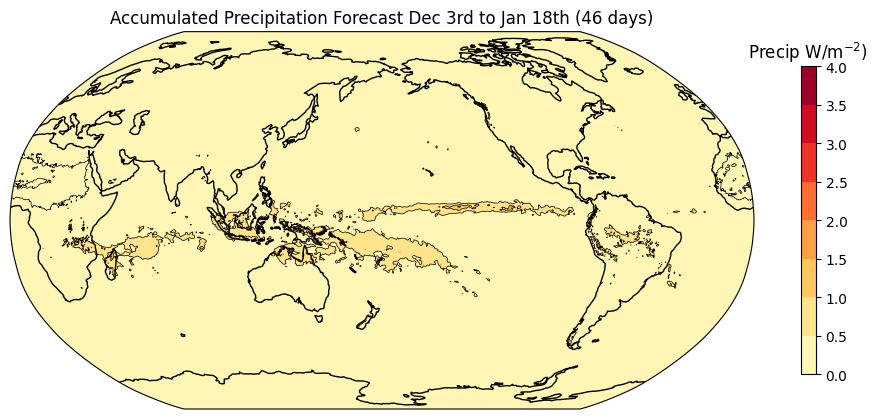

In [177]:
## Now let's make a projected global map plot using cartopy

### set up global map using cartopy
field, lon = add_cyclic_point(total_precip.sel(forecast_initial_time=slice('2024-01-01T00:00:00.000000000', '2024-02-16T00:00:00.000000000')).sum(dim='forecast_initial_time'), coord=total_precip.longitude)
lat = total_precip.latitude
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))

# add filled contours
cf = ax.contourf(lon, lat, field, cmap='YlOrRd', transform=ccrs.PlateCarree());
# add contour lines
cs = ax.contour(lon, lat, field, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# add contour labels
#lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
# add coastlines
ax.coastlines()
# add colorbar including label
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('Precip W/m$^{-2}$)')
# add title
ax.set_title('Accumulated Precipitation Forecast Dec 3rd to Jan 18th (46 days)');

In [22]:
us_total_precip = xr.open_dataset(f"Final_Data/ERA5_Total_Precipitation_USA_2023120106_2024081606.nc")
us_total_precip = us_total_precip.rename({"__xarray_dataarray_variable__":"tp"})
us_total_precip = us_total_precip.sortby("forecast_initial_time")
us_total_precip

<xarray.Dataset> Size: 241MB
Dimensions:                (forecast_initial_time: 1036, latitude: 181,
                            longitude: 321)
Coordinates:
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 8kB 2023-12...
  * latitude               (latitude) float64 1kB 60.0 59.75 59.5 ... 15.25 15.0
  * longitude              (longitude) float64 3kB 225.0 225.2 ... 304.8 305.0
Data variables:
    tp                     (forecast_initial_time, latitude, longitude) float32 241MB ...

In [ ]:
## Now let's make a projected global map plot using cartopy

# us_total_precip = total_precip.sel(longitude = slice(360-135, 360-55), latitude = slice(60,15),forecast_initial_time=slice('2024-01-01T00:00:00.000000000', '2024-02-16T00:00:00.000000000'))
### set up global map using cartopy
field, lon = add_cyclic_point(us_total_precip.sum(dim='forecast_initial_time'), coord=us_total_precip.longitude)
lat = us_total_precip.latitude
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-98))
ax.set_extent([-125, -65, 20, 55], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=1)
# add filled contours
cf = ax.contourf(lon, lat, field, cmap='cool', transform=ccrs.PlateCarree())
# add contour lines
cs = ax.contour(lon, lat, field, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# add contour labels
#lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
# add coastlines
ax.coastlines()

# add colorbar including label
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('Precip kg/m$^{-2}$')
cb.set_label('Predefined Colormap (coolwarm)')

# add title
ax.set_title('Accumulated Precipitation Forecast Dec 3rd to Jan 18th (46 days)');

AttributeError: 'Dataset' object has no attribute 'shape'

# Now we get to do some temp data :D

start_date = datetime(2024, 1, 1, 0) #2024-01-01T:00:00:00
end_date = datetime(2024, 8, 1, 0) #2024-08-01T00:00:00

date_series = []

current_date = start_date
while current_date <= end_date:
    date_series.append(current_date.strftime('%Y%m%d%H'))
    date_series.append((current_date+relativedelta(months=1)-relativedelta(hours=1)).strftime('%Y%m%d%H'))
    current_date += relativedelta(months=1)

all_data_temp = []
    
for i in range(0, len(date_series)-1, 2):
    # print(date_series[i], date_series[i+1])
    start_date = date_series[i]
    end_date = date_series[i+1]
    data_temp = xr.open_dataset(f"ERA5_Data/Temp_Output/e5.oper.an.sfc.128_167_2t.ll025sc.{start_date}_{end_date}.nc")
    
    data_temp.load()
    
    data_temp_sixth = data_temp.isel(time=slice(0, None, 6))
    #print("1")
    all_data_temp.append(data_temp_sixth)
    
total_2t_temp = xr.concat(all_data_temp, dim = 'time')

In [2]:
total_2t_temp = xr.open_dataset('Final_Data/ERA5_2m_temp_2024010100_2024083123.nc').t2m
total_2t_temp_USA = xr.open_dataset('Final_Data/ERA5_2m_temp_USA_2024010100_2024083123.nc').t2m

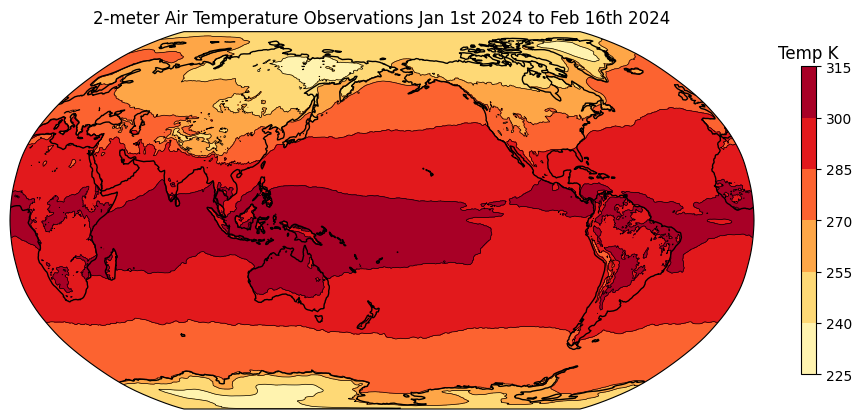

In [3]:
## Now let's make a projected global map plot using cartopy

### set up global map using cartopy
field, lon = add_cyclic_point(total_2t_temp.sel(time = slice('2024-01-01T00:00:00.000000000', '2024-02-16T00:00:00.000000000')).mean(dim='time'), coord=total_2t_temp.longitude)
lat = total_2t_temp.latitude
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))

ax._autoscaleXon = False
ax._autoscaleYon = False

# add filled contours
cf = ax.contourf(lon, lat, field, cmap='YlOrRd', transform=ccrs.PlateCarree());
# add contour lines
cs = ax.contour(lon, lat, field, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# add contour labels
#lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
# add coastlines
ax.coastlines()
# add colorbar including label
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('Temp K')
# add title
ax.set_title('2-meter Air Temperature Observations Jan 1st 2024 to Feb 16th 2024');

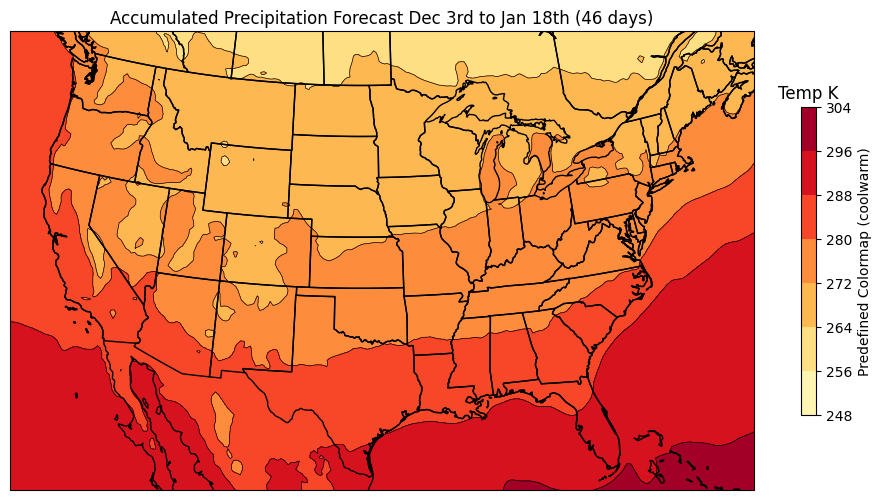

In [4]:
## Now let's make a projected global map plot using cartopy

### set up global map using cartopy
field, lon = add_cyclic_point(total_2t_temp_USA.sel(time = slice('2024-01-01T00:00:00.000000000', '2024-02-16T00:00:00.000000000')).mean(dim='time'), coord=total_2t_temp_USA.longitude)
lat = total_2t_temp_USA.latitude
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=-98))
ax.set_extent([-122, -71, 25, 50], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=1)

ax._autoscaleXon = False
ax._autoscaleYon = False

#levels = [0, 75, 150, 225, 300, 375, 450, 525, 600, 675]
# add filled contours
cf = ax.contourf(lon, lat, field, cmap='YlOrRd', transform=ccrs.PlateCarree())
# add contour lines
cs = ax.contour(lon, lat, field, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())
# add contour labels
#lb = plt.clabel(cs, fontsize=10, inline=True, fmt='%r');
# add coastlines
ax.coastlines()

# add colorbar including label
cb = plt.colorbar(cf, shrink=0.5)
cb.ax.set_title('Temp K')
cb.set_label('Predefined Colormap (coolwarm)')

# add title
ax.set_title('Accumulated Precipitation Forecast Dec 3rd to Jan 18th (46 days)');